In [1]:
import numpy as np
import scipy.stats as ss
import pylab as pl

from matplotlib import animation, rc
from IPython.display import HTML

I have the analytical expression of r_eff for multiple distribution family (gamma, normal, uniform, chi, chi2, exponential).

The goal is to find colisions.

I will also numerical validate my derivations.

$r_{\text{eff}} = \sqrt[4]{\frac{\langle r^6 \rangle}{\langle r^2 \rangle}}$ where $\langle r^n \rangle$ is the n-th raw moment: $\langle r^n \rangle = \int_{r} P(r) r^n \,\text{d}r$

In [2]:
# compute r_eff numerically
def reff_num(counts, values):
    # normalize
    counts = counts / counts.sum()
    # assume values is uniformly sample, 
    # otherwise we would have to include the d(values) in the sum
    # instead of canceling the d(values) scalar in the mom6/mom2 step
    mom6 = (counts*values**6).sum()
    mom2 = (counts*values**2).sum()
    return (mom6/mom2)**0.25

In [3]:
# r_eff for gamma distribution (k>0; shape, theta>0; scale); r in (0, +inf)
def reff_gamma(k, theta):
    return theta*((k+5)*(k+4)*(k+3)*(k+2))**0.25

In [4]:
print(reff_gamma(1e-16,1e-16))
print(reff_gamma(1e16,1e-16))
print(reff_gamma(1e-16,1e16))
print(reff_gamma(1e16,1e16))

3.309750919646873e-16
1.0000000000000004
3.3097509196468732e+16
1.0000000000000004e+32


In [5]:
gamma_reff_low = 0
gamma_reff_high = np.inf

In [6]:
# r_eff for normal distribution (mu; mean, sigma^2>0; variance); r in (-inf, +inf)
def reff_normal(mu, sigma):
    return ((mu**6+15*mu**4*sigma**2+45*mu**2*sigma**4+15*sigma**6)/(mu**2+sigma**2))**0.25

In [7]:
print(reff_normal(1e-16,1e-16))
print(reff_normal(1e16,1e-16))
print(reff_normal(1e-16,1e16))
print(reff_normal(1e16,1e16))

2.4828237961983884e-16
1e+16
1.9679896712654304e+16
2.4828237961983884e+16


In [8]:
# r_eff for uniform distribution (a; low bound, b; upper bound); x in [a, b]
def reff_uniform(a, b):
    return ((3*(a**6+a**5*b+a**4*b**2+a**3*b**3+a**2*b**4+a*b**5+b**6))/(7*(a**2+a*b+b**2)))**0.25

In [9]:
print(reff_uniform(1e-16,1e-16))
print(reff_uniform(1e16,1e-16))
print(reff_uniform(1e-16,1e16))
print(reff_uniform(1e16,1e16))

1e-16
8091067115702212.0
8091067115702212.0
1e+16


In [10]:
# r_eff for chi distribution (k>0; d.o.f.); r in [0, +inf)
def reff_chi(k):
    return ((k+4)*(k+2))**0.25

In [11]:
print(reff_chi(1e-16))
print(reff_chi(1e16))

1.681792830507429
100000000.00000001


In [12]:
# r_eff for chi2 distribution (k>0; d.o.f.); r in [0, +inf)
def reff_chi2(k):
    return 2*(((k/2)+5)*((k/2)+4)*((k/2)+3)*((k/2)+2))**0.25

In [13]:
# r_eff for exponential distribution (lambda>0; rate/inv scale); r in [0, +inf)
def reff_exp(lamb):
    return (360)**0.25 / lamb

In [14]:
# testing gamma
qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

print('mine    num     scipy')
print('---------------------')
for n_test in range(10):
    # k uniform in (1,4]
    k = 1+1*np.random.rand()
    # theta normal around 1/k
    theta = np.clip((1/4) + (1/8)*np.random.randn(), 0.1, np.inf)
    
    rv = ss.gamma(k, loc=0, scale=theta) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    
    theo_reff = reff_gamma(k, theta)
    num_reff = reff_num(pdf, rs)
    theo_scipy_reff = (rv.moment(6)/rv.moment(2))**0.25
    
    print('{:.3f}   {:.3f}   {:.3f}'.format(theo_reff, num_reff, theo_scipy_reff))

mine    num     scipy
---------------------
1.640   1.497   1.640
1.361   1.183   1.361
1.872   1.689   1.872
2.414   2.213   2.414
1.144   1.043   1.144
0.802   0.720   0.802
1.855   1.646   1.855
1.791   1.619   1.791
1.584   1.424   1.584
0.750   0.666   0.750


In [15]:
# testing gamma in graph
qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

krange = np.linspace(1.1, 10, 100)
reff_theo = []
reff_pdf = []
reff_scipy = []

for k in krange:
    theta = 1/k
    rv = ss.gamma(k, loc=0, scale=theta) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    
    reff_theo.append(reff_gamma(k, theta))
    reff_pdf.append(reff_num(pdf, rs))
    reff_scipy.append((rv.moment(6)/rv.moment(2))**0.25)

/home/raid2/paquette/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1675: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


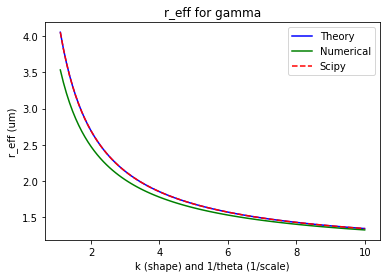

In [16]:
pl.figure()
pl.plot(krange, reff_theo, 'b', label='Theory')
pl.plot(krange, reff_pdf, 'g', label='Numerical')
pl.plot(krange, reff_scipy, '--r', label='Scipy')
pl.legend()
pl.xlabel('k (shape) and 1/theta (1/scale)')
pl.ylabel('r_eff (um)')
pl.title('r_eff for gamma')
pl.show()

In [17]:
# testing normal
qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

print('mine    num     scipy')
print('---------------------')
for n_test in range(10):
    # mu uniform in [0.5, 3]
    mu = 0.5+2.5*np.random.rand()
    # sigma uniform in [0.01, 0.1]
    sigma = 0.01+0.099*np.random.rand()
    
    rv = ss.norm(loc=mu, scale=sigma) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    
    theo_reff = reff_normal(mu, sigma)
    num_reff = reff_num(pdf, rs)
    theo_scipy_reff = (rv.moment(6)/rv.moment(2))**0.25
    
    print('{:.3f}   {:.3f}   {:.3f}'.format(theo_reff, num_reff, theo_scipy_reff))

mine    num     scipy
---------------------
1.513   1.513   1.513
2.722   2.722   2.722
2.818   2.818   2.818
2.208   2.208   2.208
2.121   2.121   2.121
0.928   0.928   0.928
2.995   2.995   2.995
0.616   0.616   0.616
1.439   1.439   1.439
0.677   0.677   0.677


In [18]:
# testing normal in graph
qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

murange = np.linspace(0.5, 3, 100)
reff_theo = []
reff_pdf = []
reff_scipy = []

for mu in murange:
    sigma = mu/4
    rv = ss.norm(loc=mu, scale=sigma) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    
    reff_theo.append(reff_normal(mu, sigma))
    reff_pdf.append(reff_num(pdf, rs))
    reff_scipy.append((rv.moment(6)/rv.moment(2))**0.25)

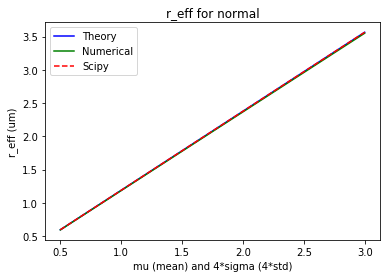

In [19]:
pl.figure()
pl.plot(murange, reff_theo, 'b', label='Theory')
pl.plot(murange, reff_pdf, 'g', label='Numerical')
pl.plot(murange, reff_scipy, '--r', label='Scipy')
pl.legend()
pl.xlabel('mu (mean) and 4*sigma (4*std)')
pl.ylabel('r_eff (um)')
pl.title('r_eff for normal')
pl.show()

In [20]:
# testing uniform
qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

print('mine    num     scipy')
print('---------------------')
for n_test in range(10):
    # a uniform in [0, 0.5]
    a = 0.5*np.random.rand()
    # sigma uniform in [a, a+5]
    b = a+5*np.random.rand()
    
    rv = ss.uniform(loc=a, scale=b-a) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    
    theo_reff = reff_uniform(a, b)
    num_reff = reff_num(pdf, rs)
    theo_scipy_reff = (rv.moment(6)/rv.moment(2))**0.25
    
    print('{:.3f}   {:.3f}   {:.3f}'.format(theo_reff, num_reff, theo_scipy_reff))

mine    num     scipy
---------------------
2.902   2.901   2.902
2.845   2.844   2.845
1.057   1.057   1.057
2.599   2.598   2.599
1.420   1.420   1.420
3.918   3.916   3.918
1.739   1.738   1.739
2.161   2.160   2.161
0.986   0.985   0.986
2.962   2.961   2.962


In [21]:
# testing uniform in graph
qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

brange = np.linspace(0.5, 10, 100)
reff_theo = []
reff_pdf = []
reff_scipy = []

for b in brange:
    a = 0
    rv = ss.uniform(loc=a, scale=b-a) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    
    reff_theo.append(reff_uniform(a, b))
    reff_pdf.append(reff_num(pdf, rs))
    reff_scipy.append((rv.moment(6)/rv.moment(2))**0.25)

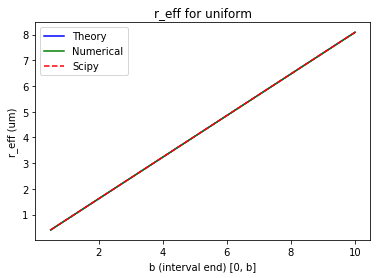

In [22]:
pl.figure()
pl.plot(brange, reff_theo, 'b', label='Theory')
pl.plot(brange, reff_pdf, 'g', label='Numerical')
pl.plot(brange, reff_scipy, '--r', label='Scipy')
pl.legend()
pl.xlabel('b (interval end) [0, b]')
pl.ylabel('r_eff (um)')
pl.title('r_eff for uniform')
pl.show()

In [23]:
# testing chi
qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

print('mine    num     scipy')
print('---------------------')
for n_test in range(10):
    # k uniform in [1.1, 10]
    k = 1.1 + 8.9*np.random.rand()
    
    rv = ss.chi(k, loc=0, scale=1) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    
    theo_reff = reff_chi(k)
    num_reff = reff_num(pdf, rs)
    theo_scipy_reff = (rv.moment(6)/rv.moment(2))**0.25
    
    print('{:.3f}   {:.3f}   {:.3f}'.format(theo_reff, num_reff, theo_scipy_reff))

mine    num     scipy
---------------------
2.731   2.705   2.731
2.282   2.241   2.282
2.408   2.372   2.408
3.469   3.453   3.469
2.949   2.927   2.949
3.030   3.009   3.030
3.447   3.431   3.447
2.158   2.109   2.158
3.127   3.107   3.127
3.348   3.330   3.348


In [24]:
# testing chi in graph
qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

krange = np.linspace(0.1, 10, 100)
reff_theo = []
reff_pdf = []
reff_scipy = []

for k in krange:
    rv = ss.chi(k, loc=0, scale=1) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    
    reff_theo.append(reff_chi(k))
    reff_pdf.append(reff_num(pdf, rs))
    reff_scipy.append((rv.moment(6)/rv.moment(2))**0.25)


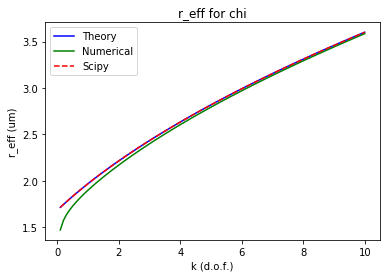

In [25]:
pl.figure()
pl.plot(krange, reff_theo, 'b', label='Theory')
pl.plot(krange, reff_pdf, 'g', label='Numerical')
pl.plot(krange, reff_scipy, '--r', label='Scipy')
pl.legend()
pl.xlabel('k (d.o.f.)')
pl.ylabel('r_eff (um)')
pl.title('r_eff for chi')
pl.show()

In [26]:
# testing chi2
qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

print('mine    num     scipy')
print('---------------------')
for n_test in range(10):
    # k uniform in [1.1, 10]
    k = 1.1 + 8.9*np.random.rand()
    
    rv = ss.chi2(k, loc=0, scale=1) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    
    theo_reff = reff_chi2(k)
    num_reff = reff_num(pdf, rs)
    theo_scipy_reff = (rv.moment(6)/rv.moment(2))**0.25
    
    print('{:.3f}   {:.3f}   {:.3f}'.format(theo_reff, num_reff, theo_scipy_reff))

mine    num     scipy
---------------------
9.789   8.803   9.789
14.185   13.556   14.185
14.034   13.398   14.034
14.770   14.166   14.770
8.031   6.620   8.031
15.112   14.521   15.112
11.650   10.869   11.650
13.117   12.435   13.117
15.298   14.714   15.298
12.301   11.569   12.301


In [27]:
# testing chi2 in graph
qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

krange = np.linspace(0.1, 10, 100)
reff_theo = []
reff_pdf = []
reff_scipy = []

for k in krange:
    rv = ss.chi2(k, loc=0, scale=1) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    
    reff_theo.append(reff_chi2(k))
    reff_pdf.append(reff_num(pdf, rs))
    reff_scipy.append((rv.moment(6)/rv.moment(2))**0.25)


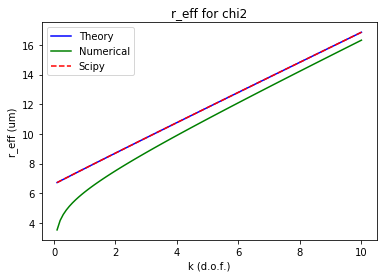

In [28]:
pl.figure()
pl.plot(krange, reff_theo, 'b', label='Theory')
pl.plot(krange, reff_pdf, 'g', label='Numerical')
pl.plot(krange, reff_scipy, '--r', label='Scipy')
pl.legend()
pl.xlabel('k (d.o.f.)')
pl.ylabel('r_eff (um)')
pl.title('r_eff for chi2')
pl.show()

In [29]:
# testing exp
qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

print('mine    num     scipy')
print('---------------------')
for n_test in range(10):
    # lambda uniform in [0.5, 5]
    lamb = 0.5 + 4.5*np.random.rand()
    
    rv = ss.expon(loc=0, scale=1/lamb) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    
    theo_reff = reff_exp(lamb)
    num_reff = reff_num(pdf, rs)
    theo_scipy_reff = (rv.moment(6)/rv.moment(2))**0.25
    
    print('{:.3f}   {:.3f}   {:.3f}'.format(theo_reff, num_reff, theo_scipy_reff))

mine    num     scipy
---------------------
1.298   1.120   1.298
0.886   0.765   0.886
1.196   1.032   1.196
1.814   1.566   1.814
1.995   1.722   1.995
1.338   1.155   1.338
0.899   0.776   0.899
0.882   0.761   0.882
3.306   2.853   3.306
2.138   1.845   2.138


In [30]:
# testing exp in graph
qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

lambrange = np.linspace(0.5, 5, 100)
reff_theo = []
reff_pdf = []
reff_scipy = []

for lamb in lambrange:
    rv = ss.expon(loc=0, scale=1/lamb) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    
    reff_theo.append(reff_exp(lamb))
    reff_pdf.append(reff_num(pdf, rs))
    reff_scipy.append((rv.moment(6)/rv.moment(2))**0.25)


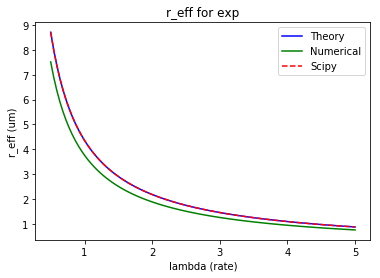

In [31]:
pl.figure()
pl.plot(lambrange, reff_theo, 'b', label='Theory')
pl.plot(lambrange, reff_pdf, 'g', label='Numerical')
pl.plot(lambrange, reff_scipy, '--r', label='Scipy')
pl.legend()
pl.xlabel('lambda (rate)')
pl.ylabel('r_eff (um)')
pl.title('r_eff for exp')
pl.show()

In [32]:
def bracket_finder(value, func, startpoint=0):
    # finds (a,b) such that func(a) < value < func(b)
    # a,b > 0
    # assume monotone function
    # attempt to find if increasing or decreasing 
    if func(1) < func(10):
        k = 2.
    else:
        k = 0.5
    
    a = 2.**startpoint
    while func(a) >= value:
        a /= k
        
    b = 2**startpoint
    while func(b) <= value:
        b *= k
    return [a, b]

In [33]:
from scipy.optimize import root_scalar

In [34]:
# find r_eff corresponding chi2(k2) for a fixed chi(k1)
target_r_eff = reff_chi(100)

def objfunc(k):
    return target_r_eff - reff_chi2(k)

sol = root_scalar(objfunc, bracket=(1,5), xtol=1e-6)

print(target_r_eff)
print(reff_chi2(sol.root))

10.14865239904638
10.14865239917269


In [35]:
# find r_eff corresponding exp(lamb) for a fixed chi(k1)
target_r_eff = reff_chi(3)

def objfunc(lamb):
    return target_r_eff - reff_exp(lamb)

sol = root_scalar(objfunc, bracket=(1,3), xtol=1e-6)

print(target_r_eff)
print(reff_exp(sol.root))

2.4322992790977875
2.432299247265632


# Let's look at some pairs

In [36]:
# find systematic chi and exp
krange = np.linspace(1.1, 10, 100)
_reff_chi = []
lambrange = []
_reff_exp = []
for k in krange:
    target_r_eff = reff_chi(k)
    _reff_chi.append(target_r_eff)
    def objfunc(lamb):
        return target_r_eff - reff_exp(lamb)
    a,b = bracket_finder(0, objfunc)
    sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
    lambrange.append(sol.root)
    _reff_exp.append(reff_exp(sol.root))

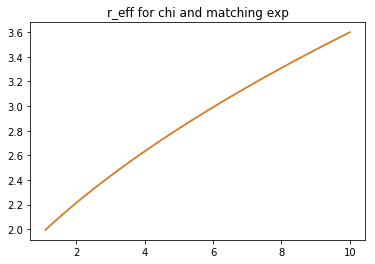

In [37]:
pl.figure()
pl.plot(krange, _reff_chi, label='chi')
pl.plot(krange, _reff_exp, label='exp')
pl.title('r_eff for chi and matching exp')
pl.show()

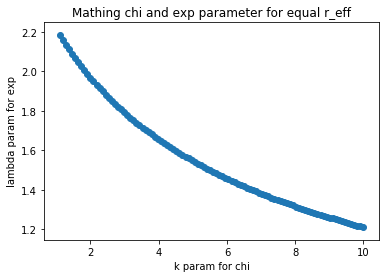

In [38]:
pl.figure()
pl.scatter(krange, lambrange)
pl.xlabel('k param for chi')
pl.ylabel('lambda param for exp')
pl.title('Mathing chi and exp parameter for equal r_eff')
pl.show()

In [39]:
# # plot the pairs of matching distribution
# qmin = 0.001 # min quantile
# qmax = 0.999 # max quantile

# for i in range(0, len(krange)):
#     pl.figure()
    
#     # exponential
#     lamb = lambrange[i]
#     rv = ss.expon(loc=0, scale=1/lamb) # define random variable
#     rmin = rv.ppf(qmin) # find r corresponding to qmin
#     rmax = rv.ppf(qmax) # find r corresponding to qmax
#     rs = np.linspace(rmin, rmax, 1000, endpoint=True)
#     pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='exp')
    
#     # chi
#     k = krange[i]
#     rv = ss.chi(k, loc=0, scale=1) # define random variable
#     rmin = rv.ppf(qmin) # find r corresponding to qmin
#     rmax = rv.ppf(qmax) # find r corresponding to qmax
#     rs = np.linspace(rmin, rmax, 1000, endpoint=True)
#     pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='chi')

#     pl.show()

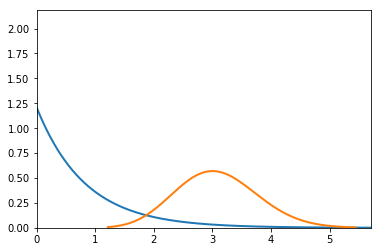

In [40]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = pl.subplots()

qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

rv11 = ss.expon(loc=0, scale=1/lambrange[0])
rv12 = ss.expon(loc=0, scale=1/lambrange[-1])

xmin_1 = min(min(rv11.ppf(qmin), rv12.ppf(qmin)), min(rv11.ppf(qmax), rv12.ppf(qmax)))
xmax_1 = max(max(rv11.ppf(qmin), rv12.ppf(qmin)), max(rv11.ppf(qmax), rv12.ppf(qmax)))

ymin_1 = min(min(rv11.pdf(rv11.ppf(qmin)), rv12.pdf(rv12.ppf(qmin))), min(rv11.pdf(rv11.ppf(qmax)), rv12.pdf(rv12.ppf(qmax))))
ymax_1 = max(max(rv11.pdf(rv11.ppf(qmin)), rv12.pdf(rv12.ppf(qmin))), max(rv11.pdf(rv11.ppf(qmax)), rv12.pdf(rv12.ppf(qmax))))


rv21 = ss.chi(krange[0], loc=0, scale=1)
rv22 = ss.chi(krange[-1], loc=0, scale=1)

xmin_2 = min(min(rv21.ppf(qmin), rv22.ppf(qmin)), min(rv21.ppf(qmax), rv22.ppf(qmax)))
xmax_2 = max(max(rv21.ppf(qmin), rv22.ppf(qmin)), max(rv21.ppf(qmax), rv22.ppf(qmax)))

ymin_2 = min(min(rv21.pdf(rv21.ppf(qmin)), rv22.pdf(rv22.ppf(qmin))), min(rv21.pdf(rv21.ppf(qmax)), rv22.pdf(rv22.ppf(qmax))))
ymax_2 = max(max(rv21.pdf(rv21.ppf(qmin)), rv22.pdf(rv22.ppf(qmin))), max(rv21.pdf(rv21.ppf(qmax)), rv22.pdf(rv22.ppf(qmax))))


# ax.set_xlim((min(xmin_1, xmin_2), max(xmax_1, xmax_2)))
# ax.set_ylim((min(ymin_1, ymin_2), max(ymax_1, ymax_2)))
ax.set_xlim((0, max(xmax_1, xmax_2)))
ax.set_ylim((0, max(ymax_1, ymax_2)))

line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)


# initialization function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return (line1, line2)

# animation function. This is called sequentially
def animate(i):
    
    # exponential
    lamb = lambrange[i]
    rv = ss.expon(loc=0, scale=1/lamb) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='exp')
    line1.set_data(rs, pdf)
    
    # chi
    k = krange[i]
    rv = ss.chi(k, loc=0, scale=1) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='chi')
    line2.set_data(rs, pdf)

    return (line1, line2)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(murange), interval=20, blit=True)

HTML(anim.to_html5_video())

In [41]:
# find systematic gamma(peak=1) and exp
krange = np.linspace(1.1, 10, 100)
thetarange = []
_reff_gamma = []
lambrange = []
_reff_exp = []
for k in krange:
    # we want peak = 1
    # peak = (k-1)*theta
    theta = 1/(k-1)
    thetarange.append(theta)
    target_r_eff = reff_gamma(k, theta)
    _reff_gamma.append(target_r_eff)
    def objfunc(lamb):
        return target_r_eff - reff_exp(lamb)
    a,b = bracket_finder(0, objfunc)
    sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
    lambrange.append(sol.root)
    _reff_exp.append(reff_exp(sol.root))

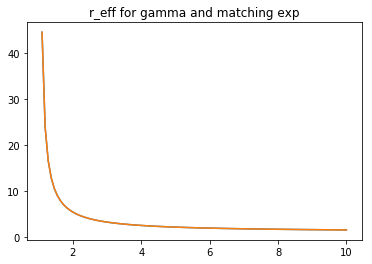

In [42]:
pl.figure()
pl.plot(krange, _reff_gamma, label='gamma')
pl.plot(krange, _reff_exp, label='exp')
pl.title('r_eff for gamma and matching exp')
pl.show()

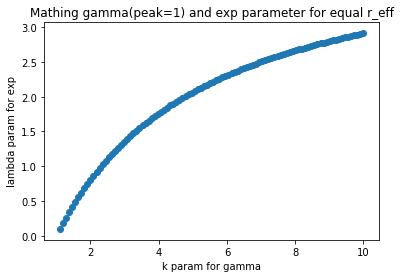

In [43]:
pl.figure()
pl.scatter(krange, lambrange)
pl.xlabel('k param for gamma')
pl.ylabel('lambda param for exp')
pl.title('Mathing gamma(peak=1) and exp parameter for equal r_eff')
pl.show()

In [44]:
# # plot the pairs of matching distribution
# qmin = 0.001 # min quantile
# qmax = 0.999 # max quantile

# for i in range(0, len(lambrange)):
#     pl.figure()
    
#     # exponential
#     lamb = lambrange[i]
#     rv = ss.expon(loc=0, scale=1/lamb) # define random variable
#     rmin = rv.ppf(qmin) # find r corresponding to qmin
#     rmax = rv.ppf(qmax) # find r corresponding to qmax
#     rs = np.linspace(rmin, rmax, 1000, endpoint=True)
#     pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='exp')
    
#     # gamma
#     k = krange[i]
#     theta = thetarange[i]
#     rv = ss.gamma(k, loc=0, scale=theta) # define random variable
#     rmin = rv.ppf(qmin) # find r corresponding to qmin
#     rmax = rv.ppf(qmax) # find r corresponding to qmax
#     rs = np.linspace(rmin, rmax, 1000, endpoint=True)
#     pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='gamma')
    
#     pl.show()

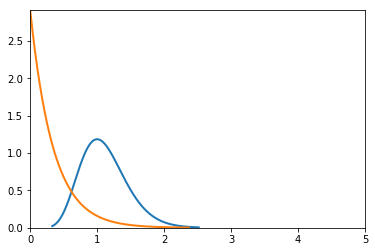

In [45]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = pl.subplots()

qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

rv11 = ss.expon(loc=0, scale=1/lambrange[0])
rv12 = ss.expon(loc=0, scale=1/lambrange[-1])

xmin_1 = min(min(rv11.ppf(qmin), rv12.ppf(qmin)), min(rv11.ppf(qmax), rv12.ppf(qmax)))
xmax_1 = max(max(rv11.ppf(qmin), rv12.ppf(qmin)), max(rv11.ppf(qmax), rv12.ppf(qmax)))

ymin_1 = min(min(rv11.pdf(rv11.ppf(qmin)), rv12.pdf(rv12.ppf(qmin))), min(rv11.pdf(rv11.ppf(qmax)), rv12.pdf(rv12.ppf(qmax))))
ymax_1 = max(max(rv11.pdf(rv11.ppf(qmin)), rv12.pdf(rv12.ppf(qmin))), max(rv11.pdf(rv11.ppf(qmax)), rv12.pdf(rv12.ppf(qmax))))


rv21 = ss.gamma(krange[0], loc=0, scale=thetarange[0])
rv22 = ss.gamma(krange[-1], loc=0, scale=thetarange[-1])


xmin_2 = min(min(rv21.ppf(qmin), rv22.ppf(qmin)), min(rv21.ppf(qmax), rv22.ppf(qmax)))
xmax_2 = max(max(rv21.ppf(qmin), rv22.ppf(qmin)), max(rv21.ppf(qmax), rv22.ppf(qmax)))

ymin_2 = min(min(rv21.pdf(rv21.ppf(qmin)), rv22.pdf(rv22.ppf(qmin))), min(rv21.pdf(rv21.ppf(qmax)), rv22.pdf(rv22.ppf(qmax))))
ymax_2 = max(max(rv21.pdf(rv21.ppf(qmin)), rv22.pdf(rv22.ppf(qmin))), max(rv21.pdf(rv21.ppf(qmax)), rv22.pdf(rv22.ppf(qmax))))



# ax.set_xlim((min(xmin_1, xmin_2), max(xmax_1, xmax_2)))
# ax.set_ylim((min(ymin_1, ymin_2), max(ymax_1, ymax_2)))
# ax.set_xlim((0, max(xmax_1, xmax_2)))
ax.set_ylim((0, max(ymax_1, ymax_2)))
ax.set_xlim((0, 5))
# ax.set_ylim((0, max(ymin_2, ymax_2)))

line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)


# initialization function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return (line1, line2)

# animation function. This is called sequentially
def animate(i):
    
    # gamma
    k = krange[i]
    theta = thetarange[i]
    rv = ss.gamma(k, loc=0, scale=theta) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='gamma')
    line1.set_data(rs, pdf)
    
    # exponential
    lamb = lambrange[i]
    rv = ss.expon(loc=0, scale=1/lamb) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='exp')
    line2.set_data(rs, pdf)

    return (line1, line2)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(murange), interval=20, blit=True)

HTML(anim.to_html5_video())

In [46]:
# find systematic gamma(peak=1) and uniform(0,b)
krange = np.linspace(1.1, 10, 100)
thetarange = []
_reff_gamma = []
arange = []
brange = []
_reff_uniform = []
for k in krange:
    # we want peak = 1
    # peak = (k-1)*theta
    theta = 1/(k-1)
    thetarange.append(theta)
    target_r_eff = reff_gamma(k, theta)
    _reff_gamma.append(target_r_eff)
    def objfunc(b):
        return target_r_eff - reff_uniform(0, b)
    a,b = bracket_finder(0, objfunc)
    sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
    arange.append(0)
    brange.append(sol.root)
    _reff_uniform.append(reff_uniform(0, sol.root))

In [47]:
# print(krange[0])
# print(thetarange[0])
# print(reff_gamma(krange[0], thetarange[0]))
# print(brange[0])
# print(reff_uniform(0, brange[0]))
# target_r_eff = reff_gamma(krange[0], thetarange[0])
# def objfunc(b):
#     return target_r_eff - reff_uniform(0, b)
# a,b = bracket_finder(0, objfunc)
# print(a)
# print(reff_uniform(0, a))
# print(b)
# print(reff_uniform(0, b))
# sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
# print(reff_uniform(0, sol.root))

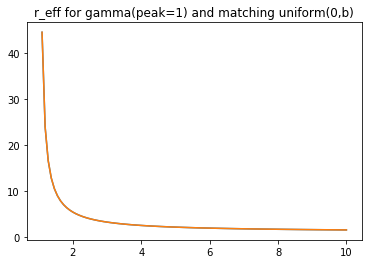

In [48]:
pl.figure()
pl.plot(krange, _reff_gamma, label='gamma')
pl.plot(krange, _reff_uniform, label='uniform')
pl.title('r_eff for gamma(peak=1) and matching uniform(0,b)')
pl.show()

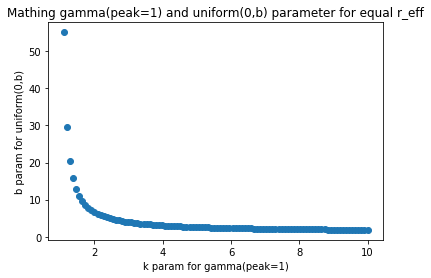

In [49]:
pl.figure()
pl.scatter(krange, brange)
pl.xlabel('k param for gamma(peak=1)')
pl.ylabel('b param for uniform(0,b)')
pl.title('Mathing gamma(peak=1) and uniform(0,b) parameter for equal r_eff')
pl.show()

In [50]:
# # plot the pairs of matching distribution
# qmin = 0.001 # min quantile
# qmax = 0.999 # max quantile

# for i in range(0, len(brange)):
#     pl.figure()
    
#     # uniform
#     a = arange[i]
#     b = brange[i]
#     rv = ss.uniform(loc=a, scale=b-a) # define random variable
#     rmin = rv.ppf(qmin) # find r corresponding to qmin
#     rmax = rv.ppf(qmax) # find r corresponding to qmax
#     rs = np.linspace(rmin, rmax, 1000, endpoint=True)
#     pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='uniform')
    
#     # gamma
#     k = krange[i]
#     theta = thetarange[i]
#     rv = ss.gamma(k, loc=0, scale=theta) # define random variable
#     rmin = rv.ppf(qmin) # find r corresponding to qmin
#     rmax = rv.ppf(qmax) # find r corresponding to qmax
#     rs = np.linspace(rmin, rmax, 1000, endpoint=True)
#     pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='gamma')
    
#     pl.show()

In [51]:
# find systematic exp and uniform(0,b)
lambrange = np.linspace(0.5, 5, 100)
_reff_exp = []
arange = []
brange = []
_reff_uniform = []
for lamb in lambrange:
    target_r_eff = reff_exp(lamb)
    _reff_exp.append(target_r_eff)
    def objfunc(b):
        return target_r_eff - reff_uniform(0, b)
    a,b = bracket_finder(0, objfunc)
    sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
    arange.append(0)
    brange.append(sol.root)
    _reff_uniform.append(reff_uniform(0, sol.root))

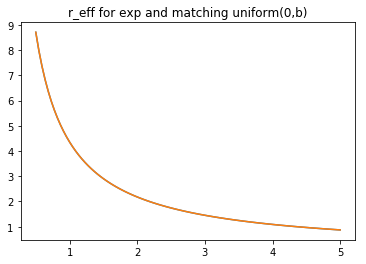

In [52]:
pl.figure()
pl.plot(lambrange, _reff_exp, label='exp')
pl.plot(lambrange, _reff_uniform, label='uniform')
pl.title('r_eff for exp and matching uniform(0,b)')
pl.show()

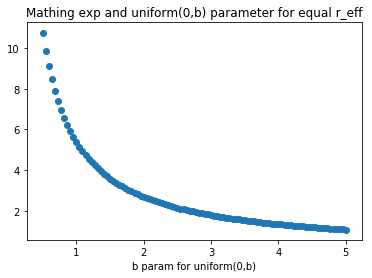

In [53]:
pl.figure()
pl.scatter(lambrange, brange)
pl.xlabel('lambda param for exp')
pl.xlabel('b param for uniform(0,b)')
pl.title('Mathing exp and uniform(0,b) parameter for equal r_eff')
pl.show()

In [54]:
# # plot the pairs of matching distribution
# qmin = 0.001 # min quantile
# qmax = 0.999 # max quantile

# for i in range(0, len(brange)):
#     pl.figure()
    
#     # uniform
#     a = arange[i]
#     b = brange[i]
#     rv = ss.uniform(loc=a, scale=b-a) # define random variable
#     rmin = rv.ppf(qmin) # find r corresponding to qmin
#     rmax = rv.ppf(qmax) # find r corresponding to qmax
#     rs = np.linspace(rmin, rmax, 1000, endpoint=True)
#     pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='uniform')
    
#     # exponential
#     lamb = lambrange[i]
#     rv = ss.expon(loc=0, scale=1/lamb) # define random variable
#     rmin = rv.ppf(qmin) # find r corresponding to qmin
#     rmax = rv.ppf(qmax) # find r corresponding to qmax
#     rs = np.linspace(rmin, rmax, 1000, endpoint=True)
#     pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='exp')
    
#     pl.show()

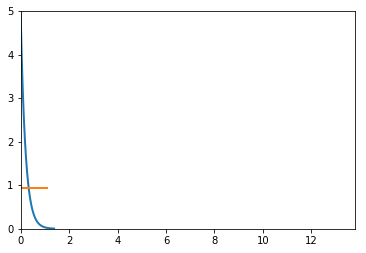

In [55]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = pl.subplots()

qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

rv11 = ss.expon(loc=0, scale=1/lambrange[0])
rv12 = ss.expon(loc=0, scale=1/lambrange[-1])

xmin_1 = min(min(rv11.ppf(qmin), rv12.ppf(qmin)), min(rv11.ppf(qmax), rv12.ppf(qmax)))
xmax_1 = max(max(rv11.ppf(qmin), rv12.ppf(qmin)), max(rv11.ppf(qmax), rv12.ppf(qmax)))

ymin_1 = min(min(rv11.pdf(rv11.ppf(qmin)), rv12.pdf(rv12.ppf(qmin))), min(rv11.pdf(rv11.ppf(qmax)), rv12.pdf(rv12.ppf(qmax))))
ymax_1 = max(max(rv11.pdf(rv11.ppf(qmin)), rv12.pdf(rv12.ppf(qmin))), max(rv11.pdf(rv11.ppf(qmax)), rv12.pdf(rv12.ppf(qmax))))


rv21 = ss.uniform(loc=arange[0], scale=brange[0]-arange[0])
rv22 = ss.uniform(loc=arange[-1], scale=brange[-1]-arange[-1])

xmin_2 = min(min(rv21.ppf(qmin), rv22.ppf(qmin)), min(rv21.ppf(qmax), rv22.ppf(qmax)))
xmax_2 = max(max(rv21.ppf(qmin), rv22.ppf(qmin)), max(rv21.ppf(qmax), rv22.ppf(qmax)))

ymin_2 = min(min(rv21.pdf(rv21.ppf(qmin)), rv22.pdf(rv22.ppf(qmin))), min(rv21.pdf(rv21.ppf(qmax)), rv22.pdf(rv22.ppf(qmax))))
ymax_2 = max(max(rv21.pdf(rv21.ppf(qmin)), rv22.pdf(rv22.ppf(qmin))), max(rv21.pdf(rv21.ppf(qmax)), rv22.pdf(rv22.ppf(qmax))))


# ax.set_xlim((min(xmin_1, xmin_2), max(xmax_1, xmax_2)))
# ax.set_ylim((min(ymin_1, ymin_2), max(ymax_1, ymax_2)))
ax.set_xlim((0, max(xmax_1, xmax_2)))
ax.set_ylim((0, max(ymax_1, ymax_2)))

line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)


# initialization function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return (line1, line2)

# animation function. This is called sequentially
def animate(i):
    
    # exponential
    lamb = lambrange[i]
    rv = ss.expon(loc=0, scale=1/lamb) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='exp')
    line1.set_data(rs, pdf)
    
    # uniform
    a = arange[i]
    b = brange[i]
    rv = ss.uniform(loc=a, scale=b-a) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='uniform')
    line2.set_data(rs, pdf)

    return (line1, line2)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(murange), interval=20, blit=True)

HTML(anim.to_html5_video())

In [56]:
# find systematic normal and exp
murange = np.linspace(0.5, 3, 100)
sigmarange = []
_reff_normal = []
lambrange = []
_reff_exp = []
for mu in murange:
    sigma = 0.1
    sigmarange.append(sigma)
    target_r_eff = reff_normal(mu, sigma)
    _reff_normal.append(target_r_eff)
    def objfunc(lamb):
        return target_r_eff - reff_exp(lamb)
    a,b = bracket_finder(0, objfunc)
    sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
    lambrange.append(sol.root)
    _reff_exp.append(reff_exp(sol.root))

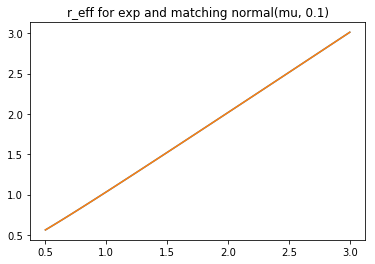

In [57]:
pl.figure()
pl.plot(murange, _reff_normal, label='normal')
pl.plot(murange, _reff_exp, label='exp')
pl.title('r_eff for exp and matching normal(mu, 0.1)')
pl.show()

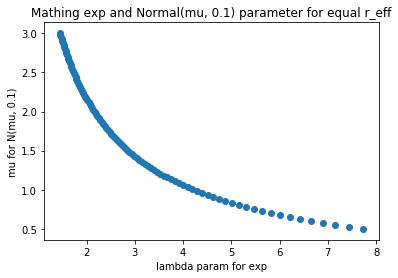

In [58]:
pl.figure()
pl.scatter(lambrange, murange)
pl.xlabel('lambda param for exp')
pl.ylabel('mu for N(mu, 0.1)')
pl.title('Mathing exp and Normal(mu, 0.1) parameter for equal r_eff')
pl.show()

In [59]:
# # plot the pairs of matching distribution
# qmin = 0.001 # min quantile
# qmax = 0.999 # max quantile

# for i in range(0, len(murange)):
#     pl.figure()
    
#     # exponential
#     lamb = lambrange[i]
#     rv = ss.expon(loc=0, scale=1/lamb) # define random variable
#     rmin = rv.ppf(qmin) # find r corresponding to qmin
#     rmax = rv.ppf(qmax) # find r corresponding to qmax
#     rs = np.linspace(rmin, rmax, 1000, endpoint=True)
#     pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='exp')
    
#     # normal
#     mu = murange[i]
#     sigma = sigmarange[i]
#     rv = ss.norm(loc=mu, scale=sigma) # define random variable
#     rmin = rv.ppf(qmin) # find r corresponding to qmin
#     rmax = rv.ppf(qmax) # find r corresponding to qmax
#     rs = np.linspace(rmin, rmax, 1000, endpoint=True)
#     pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='normal')
    
#     pl.show()

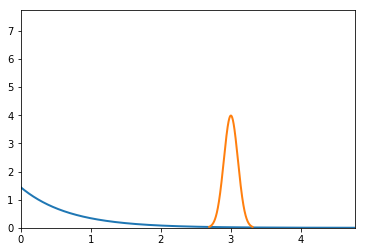

In [60]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = pl.subplots()

qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

rv11 = ss.expon(loc=0, scale=1/lambrange[0])
rv12 = ss.expon(loc=0, scale=1/lambrange[-1])

xmin_1 = min(min(rv11.ppf(qmin), rv12.ppf(qmin)), min(rv11.ppf(qmax), rv12.ppf(qmax)))
xmax_1 = max(max(rv11.ppf(qmin), rv12.ppf(qmin)), max(rv11.ppf(qmax), rv12.ppf(qmax)))

ymin_1 = min(min(rv11.pdf(rv11.ppf(qmin)), rv12.pdf(rv12.ppf(qmin))), min(rv11.pdf(rv11.ppf(qmax)), rv12.pdf(rv12.ppf(qmax))))
ymax_1 = max(max(rv11.pdf(rv11.ppf(qmin)), rv12.pdf(rv12.ppf(qmin))), max(rv11.pdf(rv11.ppf(qmax)), rv12.pdf(rv12.ppf(qmax))))


rv21 = ss.norm(loc=murange[0], scale=sigmarange[0])
rv22 = ss.norm(loc=murange[-1], scale=sigmarange[-1])

xmin_2 = min(min(rv21.ppf(qmin), rv22.ppf(qmin)), min(rv21.ppf(qmax), rv22.ppf(qmax)))
xmax_2 = max(max(rv21.ppf(qmin), rv22.ppf(qmin)), max(rv21.ppf(qmax), rv22.ppf(qmax)))

ymin_2 = min(min(rv21.pdf(rv21.ppf(qmin)), rv22.pdf(rv22.ppf(qmin))), min(rv21.pdf(rv21.ppf(qmax)), rv22.pdf(rv22.ppf(qmax))))
ymax_2 = max(max(rv21.pdf(rv21.ppf(qmin)), rv22.pdf(rv22.ppf(qmin))), max(rv21.pdf(rv21.ppf(qmax)), rv22.pdf(rv22.ppf(qmax))))


# ax.set_xlim((min(xmin_1, xmin_2), max(xmax_1, xmax_2)))
# ax.set_ylim((min(ymin_1, ymin_2), max(ymax_1, ymax_2)))
ax.set_xlim((0, max(xmax_1, xmax_2)))
ax.set_ylim((0, max(ymax_1, ymax_2)))

line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)


# initialization function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return (line1, line2)

# animation function. This is called sequentially
def animate(i):
    
    # exponential
    lamb = lambrange[i]
    rv = ss.expon(loc=0, scale=1/lamb) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='exp')
    line1.set_data(rs, pdf)
    
    # normal
    mu = murange[i]
    sigma = sigmarange[i]
    rv = ss.norm(loc=mu, scale=sigma) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='normal')
    line2.set_data(rs, pdf)

    return (line1, line2)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(murange), interval=20, blit=True)

HTML(anim.to_html5_video())

In [61]:
# find systematic normal and gamma(peak=1)
krange = np.linspace(1.1, 10, 100)
thetarange = []
_reff_gamma = []
murange = []
sigmarange = []
_reff_normal = []
for k in krange:
    # we want peak = 1
    # peak = (k-1)*theta
    theta = 1/(k-1)
    thetarange.append(theta)
    target_r_eff = reff_gamma(k, theta)
    _reff_gamma.append(target_r_eff)
    sigma = 0.1
    def objfunc(mu):
        return target_r_eff - reff_normal(mu, sigma)
    a,b = bracket_finder(0, objfunc)
    sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
    murange.append(sol.root)
    sigmarange.append(sigma)
    _reff_normal.append(reff_normal(sol.root, sigma))

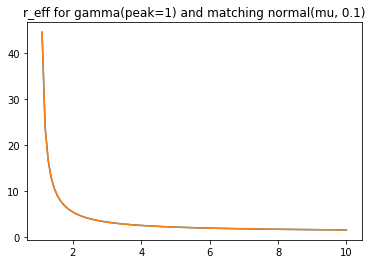

In [62]:
pl.figure()
pl.plot(krange, _reff_normal, label='normal')
pl.plot(krange, _reff_gamma, label='gamma')
pl.title('r_eff for gamma(peak=1) and matching normal(mu, 0.1)')
pl.show()

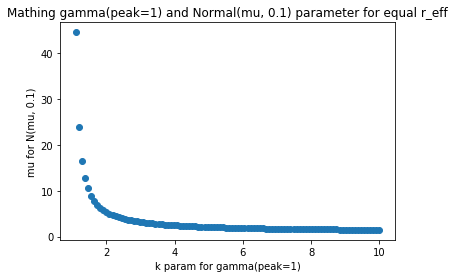

In [63]:
pl.figure()
pl.scatter(krange, murange)
pl.xlabel('k param for gamma(peak=1)')
pl.ylabel('mu for N(mu, 0.1)')
pl.title('Mathing gamma(peak=1) and Normal(mu, 0.1) parameter for equal r_eff')
pl.show()

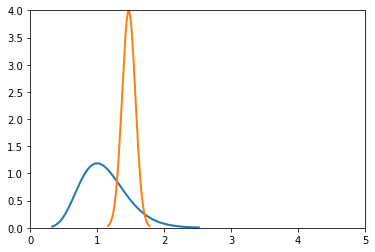

In [64]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = pl.subplots()

qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

rv11 = ss.gamma(krange[0], loc=0, scale=thetarange[0])
rv12 = ss.gamma(krange[-1], loc=0, scale=thetarange[-1])

xmin_1 = min(min(rv11.ppf(qmin), rv12.ppf(qmin)), min(rv11.ppf(qmax), rv12.ppf(qmax)))
xmax_1 = max(max(rv11.ppf(qmin), rv12.ppf(qmin)), max(rv11.ppf(qmax), rv12.ppf(qmax)))

ymin_1 = min(min(rv11.pdf(rv11.ppf(qmin)), rv12.pdf(rv12.ppf(qmin))), min(rv11.pdf(rv11.ppf(qmax)), rv12.pdf(rv12.ppf(qmax))))
ymax_1 = max(max(rv11.pdf(rv11.ppf(qmin)), rv12.pdf(rv12.ppf(qmin))), max(rv11.pdf(rv11.ppf(qmax)), rv12.pdf(rv12.ppf(qmax))))


rv21 = ss.norm(loc=murange[0], scale=sigmarange[0])
rv22 = ss.norm(loc=murange[-1], scale=sigmarange[-1])

xmin_2 = 0
xmax_2 = rv21.pdf(murange[0])

ymin_2 = 0
ymax_2 = rv22.pdf(murange[-1])


# ax.set_xlim((min(xmin_1, xmin_2), max(xmax_1, xmax_2)))
# ax.set_ylim((min(ymin_1, ymin_2), max(ymax_1, ymax_2)))
# ax.set_xlim((0, max(xmax_1, xmax_2)))
# ax.set_ylim((0, max(ymax_1, ymax_2)))
ax.set_xlim((0, 5))
ax.set_ylim((0, 4))

line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)


# initialization function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return (line1, line2)

# animation function. This is called sequentially
def animate(i):
    
    # gamma
    k = krange[i]
    theta = thetarange[i]
    rv = ss.gamma(k, loc=0, scale=theta) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='gamma')
    line1.set_data(rs, pdf)
    
    # normal
    mu = murange[i]
    sigma = sigmarange[i]
    rv = ss.norm(loc=mu, scale=sigma) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='normal')
    line2.set_data(rs, pdf)

    return (line1, line2)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(murange), interval=20, blit=True)

HTML(anim.to_html5_video())

In [65]:
# find systematic gamma(peak=1) vs normal, uniform, chi, exp
from ipywidgets import IntProgress
from IPython.display import display
import time

# gamma
# krange_gamma = np.linspace(1.1, 10, 3)
krange_gamma = np.linspace(1.1, 10, 100)
thetarange_gamma = []
_reff_gamma = []

murange_normal1 = []
sigmarange_normal1 = []
_reff_normal1 = []

murange_normal2 = []
sigmarange_normal2 = []
_reff_normal2 = []

arange_uniform = []
brange_uniform = []
_reff_uniform = []

lambrange_exp = []
_reff_exp = []

krange_chi = []
_reff_chi = []


# f = IntProgress(min=0, max=len(krange_gamma))
# display(f)
for k_gamma in krange_gamma:
#     f.value += 1 # progress bar
    # we want peak = 1
    # peak = (k-1)*theta
    theta_gamma = 1/(k_gamma-1)
    thetarange_gamma.append(theta_gamma)
    target_r_eff = reff_gamma(k_gamma, theta_gamma)
    _reff_gamma.append(target_r_eff)
    
    # normal(mu, 0.1)
#     print('normal1 {}'.format(k_gamma))
    sigma_normal1 = 0.1
    sigmarange_normal1.append(sigma_normal1)
    def objfunc(x):
        return target_r_eff - reff_normal(x, sigma_normal1)
    a,b = bracket_finder(0, objfunc)
    sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
    murange_normal1.append(sol.root)
    _reff_normal1.append(reff_normal(sol.root, sigma_normal1))

    # normal(mu, 0.5)
#     print('normal2 {}'.format(k_gamma))
    sigma_normal2 = 0.5
    sigmarange_normal2.append(sigma_normal2)
    def objfunc(x):
        return target_r_eff - reff_normal(x, sigma_normal2)
    a,b = bracket_finder(0, objfunc)
    sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
    murange_normal2.append(sol.root)
    _reff_normal2.append(reff_normal(sol.root, sigma_normal2))   
    
    # uniform(0, b)
#     print('uniform {}'.format(k_gamma))
    a_uniform = 0.0
    arange_uniform.append(a_uniform)
    def objfunc(x):
        return target_r_eff - reff_uniform(a_uniform, x)
    a,b = bracket_finder(0, objfunc)
    sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
    brange_uniform.append(sol.root)
    _reff_uniform.append(reff_uniform(a_uniform, sol.root))     
    
#     # chi(k)
#     print('chi {}'.format(k_gamma))
#     def objfunc(x):
#         return target_r_eff - reff_chi(x)
#     a,b = bracket_finder(0, objfunc)
#     sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
#     krange_chi.append(sol.root)
#     _reff_chi.append(reff_chi(sol.root))
    
    # exp(lamb)
#     print('exp {}'.format(k_gamma))
    def objfunc(x):
        return target_r_eff - reff_exp(x)
    a,b = bracket_finder(0, objfunc)
    sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
    lambrange_exp.append(sol.root)
    _reff_exp.append(reff_exp(sol.root))

    

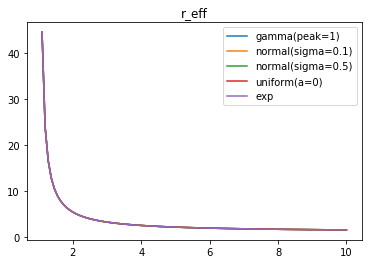

In [66]:
pl.figure()
pl.plot(krange_gamma, _reff_gamma, label='gamma(peak=1)')
pl.plot(krange_gamma, _reff_normal1, label='normal(sigma=0.1)')
pl.plot(krange_gamma, _reff_normal2, label='normal(sigma=0.5)')
pl.plot(krange_gamma, _reff_uniform, label='uniform(a=0)')
pl.plot(krange_gamma, _reff_exp, label='exp')
# pl.plot(krange_gamma, _reff_chi, label='chi')
pl.title('r_eff')
pl.legend()
pl.show()

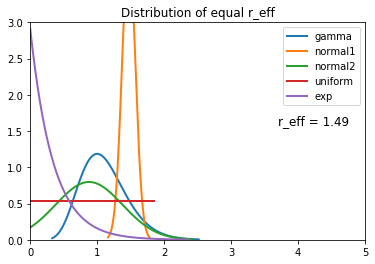

In [67]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = pl.subplots()

qmin = 0.001 # min quantile
qmax = 0.999 # max quantile

ax.set_xlim((0, 5))
ax.set_ylim((0, 3))

line_gamma, = ax.plot([], [], lw=2, label='gamma')
line_normal1, = ax.plot([], [], lw=2, label='normal1')
line_normal2, = ax.plot([], [], lw=2, label='normal2')
line_uniform, = ax.plot([], [], lw=2, label='uniform')
line_exp, = ax.plot([], [], lw=2, label='exp')
reff_text = ax.text(3.7, 1.6, '', fontsize=12)

pl.legend(loc=1)
pl.title('Distribution of equal r_eff')


# initialization function: plot the background of each frame
def init():
    line_gamma.set_data([], [])
    line_normal1.set_data([], [])
    line_normal2.set_data([], [])
    line_uniform.set_data([], [])
    line_exp.set_data([], [])
    reff_text.set_text('')
    return (line_gamma, line_normal1, line_normal2, line_uniform, line_exp, reff_text)

# animation function. This is called sequentially
def animate(i):
    
    # gamma
    k_gamma = krange_gamma[i]
    theta_gamma = thetarange_gamma[i]
    rv = ss.gamma(k_gamma, loc=0, scale=theta_gamma) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='gamma')
    line_gamma.set_data(rs, pdf)
    
    # normal1
    mu_normal1 = murange_normal1[i]
    sigma_normal1 = sigmarange_normal1[i]
    rv = ss.norm(loc=mu_normal1, scale=sigma_normal1) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='normal')
    line_normal1.set_data(rs, pdf)
    
    # normal2
    mu_normal2 = murange_normal2[i]
    sigma_normal2 = sigmarange_normal2[i]
    rv = ss.norm(loc=mu_normal2, scale=sigma_normal2) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='normal')
    line_normal2.set_data(rs, pdf)
    
    # uniform
    a_uniform = arange_uniform[i]
    b_uniform = brange_uniform[i]
    rv = ss.uniform(loc=a_uniform, scale=b_uniform-a_uniform) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='gamma')
    line_uniform.set_data(rs, pdf)

    # uniform
    lamb_exp = lambrange_exp[i]
    rv = ss.expon(loc=0, scale=1/lamb_exp) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
#     pl.plot(rs, pdf, label='gamma')
    line_exp.set_data(rs, pdf)
    
    reff_text.set_text('r_eff = {:.2f}'.format(_reff_gamma[i]))
    
    return (line_gamma, line_normal1, line_normal2, line_uniform, line_exp, reff_text)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(murange), interval=40, blit=True)

HTML(anim.to_html5_video())

In [68]:
# find systematic for Liewald2014
from ipywidgets import IntProgress
from IPython.display import display
import time


krange_gamma1 = []
thetarange_gamma1 = []
_reff_gamma1 = []

krange_gamma2 = []
thetarange_gamma2 = []
_reff_gamma2 = []

murange_normal1 = []
sigmarange_normal1 = []
_reff_normal1 = []

murange_normal2 = []
sigmarange_normal2 = []
_reff_normal2 = []

arange_uniform = []
brange_uniform = []
_reff_uniform = []

lambrange_exp = []
_reff_exp = []

krange_chi = []
_reff_chi = []


# actually thos are diameters
_target_r_eff = [2.21, 1.13]

# f = IntProgress(min=0, max=len(krange_gamma))
# display(f)
for target_r_eff in _target_r_eff:
#     f.value += 1 # progress bar

#     # we want peak = 1
#     # peak = (k-1)*theta
#     def objfunc(x):
#         return target_r_eff - reff_gamma(x, 1/(x-1))
#     a,b = bracket_finder(0, objfunc)
#     sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
#     krange_gamma.append(sol.root)
#     thetarange_gamma.append(1/(sol.root-1))
#     _reff_gamma.append(reff_gamma(sol.root, 1/(sol.root-1)))
    
    
    # we want peak = 1
    # peak = (k-1)*theta
    peak = 1.
    def objfunc(x):
        return target_r_eff - reff_gamma((peak/x)+1, x)
    a,b = bracket_finder(0, objfunc)
    sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
    krange_gamma1.append((peak/sol.root)+1)
    thetarange_gamma1.append(sol.root)
    _reff_gamma1.append(reff_gamma((peak/sol.root)+1, sol.root))

    # we want peak = 0.5
    # peak = (k-1)*theta
    peak = 0.5
    def objfunc(x):
        return target_r_eff - reff_gamma((peak/x)+1, x)
    a,b = bracket_finder(0, objfunc)
    sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
    krange_gamma2.append((peak/sol.root)+1)
    thetarange_gamma2.append(sol.root)
    _reff_gamma2.append(reff_gamma((peak/sol.root)+1, sol.root))
    
    # normal(mu, 0.2)
#     print('normal1 {}'.format(k_gamma))
    sigma_normal1 = 0.2
    sigmarange_normal1.append(sigma_normal1)
    def objfunc(x):
        return target_r_eff - reff_normal(x, sigma_normal1)
    a,b = bracket_finder(0, objfunc)
    sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
    murange_normal1.append(sol.root)
    _reff_normal1.append(reff_normal(sol.root, sigma_normal1))

#     # normal(mu, 0.5)
# #     print('normal2 {}'.format(k_gamma))
#     sigma_normal2 = 0.5
#     sigmarange_normal2.append(sigma_normal2)
#     def objfunc(x):
#         return target_r_eff - reff_normal(x, sigma_normal2)
#     a,b = bracket_finder(0, objfunc)
#     sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
#     murange_normal2.append(sol.root)
#     _reff_normal2.append(reff_normal(sol.root, sigma_normal2))   
    
    # uniform(0, b)
#     print('uniform {}'.format(k_gamma))
    a_uniform = 0.0
    arange_uniform.append(a_uniform)
    def objfunc(x):
        return target_r_eff - reff_uniform(a_uniform, x)
    a,b = bracket_finder(0, objfunc)
    sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
    brange_uniform.append(sol.root)
    _reff_uniform.append(reff_uniform(a_uniform, sol.root))     
    
#     # chi(k)
#     print('chi {}'.format(k_gamma))
#     def objfunc(x):
#         return target_r_eff - reff_chi(x)
#     a,b = bracket_finder(0, objfunc)
#     sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
#     krange_chi.append(sol.root)
#     _reff_chi.append(reff_chi(sol.root))
    
    # exp(lamb)
#     print('exp {}'.format(k_gamma))
    def objfunc(x):
        return target_r_eff - reff_exp(x)
    a,b = bracket_finder(0, objfunc)
    sol = root_scalar(objfunc, bracket=(a,b), xtol=1e-6)
    lambrange_exp.append(sol.root)
    _reff_exp.append(reff_exp(sol.root))

    

In [69]:
# Liewald diameter data
# data recovered from plots
data_left = np.genfromtxt('/home/raid2/paquette/Downloads/Liewald_2014_fig9_Human_brain_1_left.csv')
data_right = np.genfromtxt('/home/raid2/paquette/Downloads/Liewald_2014_fig9_Human_brain_1_right.csv')

# the bin center are known so we can correct
diams_left = np.round(data_left[:,0], 1)
diams_right = np.round(data_right[:,0], 1)
diams = [diams_left, diams_right]

# re-normalize to sum to 1
normCounts_left = data_left[:,1] / data_left[:,1].sum()
normCounts_right = data_right[:,1] / data_right[:,1].sum()
normCounts = [normCounts_left, normCounts_right]

delta_diam_left = 0.1
delta_diam_right = 0.1
delta_diam = [delta_diam_left, delta_diam_right]

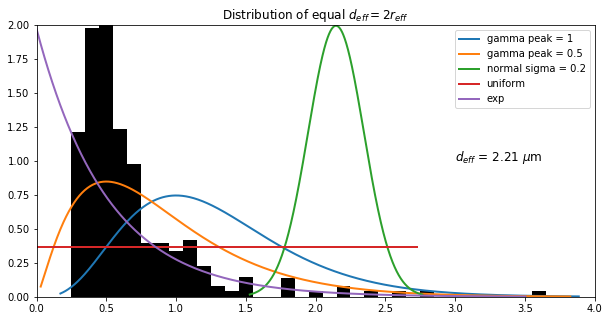

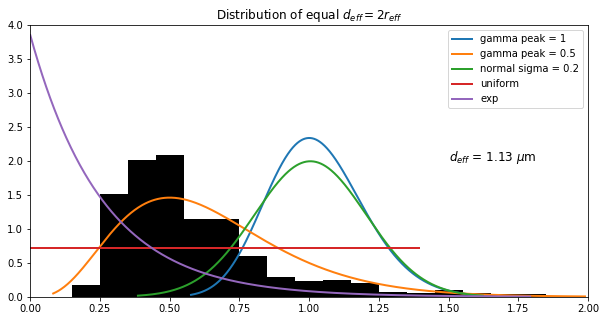

In [95]:
# First set up the figure, the axis, and the plot element we want to animate
xs = [4, 2]
ys = [2, 4]
for i in range(len(_target_r_eff)):

    fig, ax = pl.subplots(figsize=(10, 5))

    qmin = 0.001 # min quantile
    qmax = 0.999 # max quantile

#     ax.set_xlim((0, 5))
    ax.set_xlim((0, xs[i]))
#     ax.set_ylim((0, 3))
    ax.set_ylim((0, ys[i]))

    line_gamma1, = ax.plot([], [], lw=2, label='gamma peak = 1')
    line_gamma2, = ax.plot([], [], lw=2, label='gamma peak = 0.5')
    line_normal1, = ax.plot([], [], lw=2, label='normal sigma = 0.2')
#     line_normal2, = ax.plot([], [], lw=2, label='normal2')
    line_uniform, = ax.plot([], [], lw=2, label='uniform')
    line_exp, = ax.plot([], [], lw=2, label='exp')
#     reff_text = ax.text(3.7, 1.6, '', fontsize=12)
    reff_text = ax.text(xs[i]*0.75, ys[i]*0.5, '', fontsize=12)
    
    pl.legend(loc=1)
    pl.title('Distribution of equal $d_{eff} = 2r_{eff}$')

    # gamma1
    k_gamma1 = krange_gamma1[i]
    theta_gamma1 = thetarange_gamma1[i]
    rv = ss.gamma(k_gamma1, loc=0, scale=theta_gamma1) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    #     pl.plot(rs, pdf, label='gamma')
    line_gamma1.set_data(rs, pdf)
    
    # gamma2
    k_gamma2 = krange_gamma2[i]
    theta_gamma2 = thetarange_gamma2[i]
    rv = ss.gamma(k_gamma2, loc=0, scale=theta_gamma2) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    #     pl.plot(rs, pdf, label='gamma')
    line_gamma2.set_data(rs, pdf)

    # normal1
    mu_normal1 = murange_normal1[i]
    sigma_normal1 = sigmarange_normal1[i]
    rv = ss.norm(loc=mu_normal1, scale=sigma_normal1) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    #     pl.plot(rs, pdf, label='normal')
    line_normal1.set_data(rs, pdf)

#     # normal2
#     mu_normal2 = murange_normal2[i]
#     sigma_normal2 = sigmarange_normal2[i]
#     rv = ss.norm(loc=mu_normal2, scale=sigma_normal2) # define random variable
#     rmin = rv.ppf(qmin) # find r corresponding to qmin
#     rmax = rv.ppf(qmax) # find r corresponding to qmax
#     rs = np.linspace(rmin, rmax, 1000, endpoint=True)
#     pdf = rv.pdf(rs) # density at those r
#     #     pl.plot(rs, pdf, label='normal')
#     line_normal2.set_data(rs, pdf)

    # uniform
    a_uniform = arange_uniform[i]
    b_uniform = brange_uniform[i]
    rv = ss.uniform(loc=a_uniform, scale=b_uniform-a_uniform) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    #     pl.plot(rs, pdf, label='gamma')
    line_uniform.set_data(rs, pdf)

    # uniform
    lamb_exp = lambrange_exp[i]
    rv = ss.expon(loc=0, scale=1/lamb_exp) # define random variable
    rmin = rv.ppf(qmin) # find r corresponding to qmin
    rmax = rv.ppf(qmax) # find r corresponding to qmax
    rs = np.linspace(rmin, rmax, 1000, endpoint=True)
    pdf = rv.pdf(rs) # density at those r
    #     pl.plot(rs, pdf, label='gamma')
    line_exp.set_data(rs, pdf)

    reff_text.set_text('$d_{{eff}}$ = {:.2f} $\mu$m'.format(_target_r_eff[i]))

    # pl.figure()
    for j in range(diams[i].shape[0]):
        pl.bar(diams[i][j], normCounts[i][j]/delta_diam[i], delta_diam[i], color='k')
    
    
pl.show()

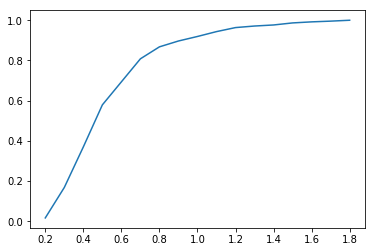

In [71]:
pl.plot(diams[1], np.cumsum(normCounts[1]))

In [72]:
# gamma with peak = 0.5 and same d_eff
rv = ss.gamma(krange_gamma2[1], loc=0, scale=thetarange_gamma2[1])
# cdf 
cdf = np.cumsum(normCounts[1])
# D, pval = ss.kstest(rv, cdf, N=20)

In [73]:
import scipy
inv_cdf = scipy.interpolate.interp1d(np.concatenate([[0],cdf]), np.concatenate([[0],diams[1]]))
r = np.random.rand(10000)
invdata = inv_cdf(r)

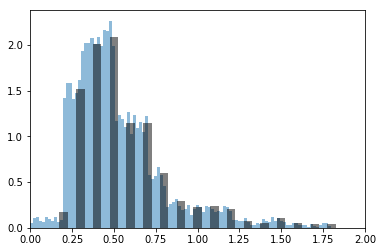

In [74]:
i=1
pl.figure()
pl.hist(invdata, bins=100, density=True, alpha=0.5)
pl.xlim(0,2)

# pl.figure()
for j in range(diams[i].shape[0]):
    pl.bar(diams[i][j], normCounts[i][j]/delta_diam[i], 0.05, color='k', alpha=0.5)
pl.xlim(0,2)

pl.show()

In [75]:
gamma2_data = rv.rvs(10000)

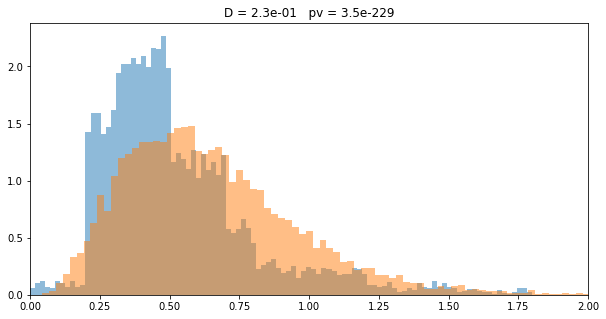

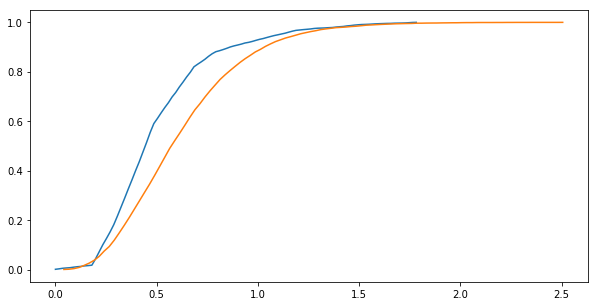

In [76]:
D, pval = ss.ks_2samp(gamma2_data, invdata)

i=1
pl.figure(figsize=(10,5))
pl.hist(invdata, bins=100, density=True, alpha=0.5)
pl.xlim(0,2)

pl.hist(gamma2_data, bins=100, density=True, alpha=0.5)
pl.xlim(0,2)

pl.title('D = {:.1e}   pv = {:.1e}'.format(D, pval))



counts1, binedge1 = np.histogram(invdata, 100)
cdf1 = np.cumsum(counts1/counts1.sum())
counts2, binedge2 = np.histogram(gamma2_data, 100)
cdf2 = np.cumsum(counts2/counts2.sum())

pl.figure(figsize=(10,5))
pl.plot(binedge1[:-1], cdf1, label='data')
pl.plot(binedge2[:-1], cdf2, label='gamma peak = 0.5')

pl.show()

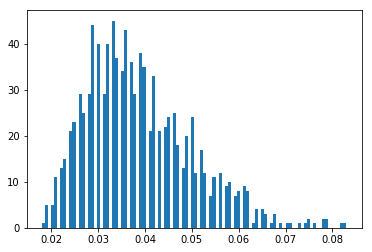

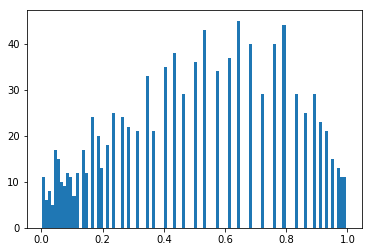

In [80]:
Ds = []
ps = []

ntrial = 1000
N = 1000

for i in range(ntrial):
    t1 = rv.rvs(N)
    t2 = rv.rvs(N)
    D, pval = ss.ks_2samp(t1, t2)
    Ds.append(D)
    ps.append(pval)

    

pl.figure()
pl.hist(Ds, bins=100)

pl.figure()
pl.hist(ps, bins=100)

pl.show()

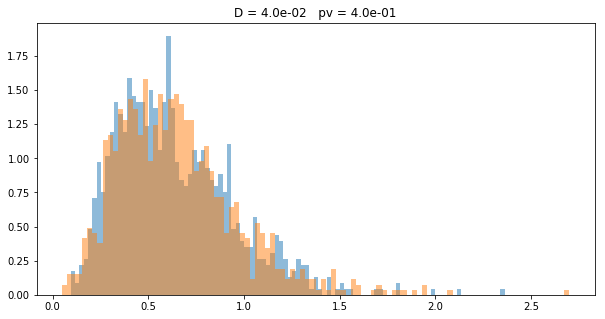

In [89]:
pl.figure(figsize=(10,5))
pl.hist(t1, bins=100, density=True, alpha=0.5)
# pl.xlim(0,2)

pl.hist(t2, bins=100, density=True, alpha=0.5)
# pl.xlim(0,2)

pl.title('D = {:.1e}   pv = {:.1e}'.format(D, pval))

pl.show()